# File Info

Learning Hopf Bifurcation using Neural_ODE_v2 framework. 

Training data will have a linearly increasing bifurcation parameter. 

Goal: To indentify if we can recover autonomous systems with fixed bifurcation parameter using Neural ODE. 

Next: Compute Largest Lyapunov Exponents for each

In [2]:
import os
import sys
from torchdiffeq import odeint as odeint

sys.path.append(os.path.abspath(".."))

import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits import mplot3d
from numpy import linalg as la
from scipy import stats
from scipy import spatial as sp
from scipy import integrate as integ
import pandas as pd
import torch
import torch.nn as nn
from tqdm import tqdm
from ipywidgets import interact, IntSlider
import types

import models.Neural_ODEs_v2 as nodes
import models.DynamicalSystems as ds

# Data Generation



In [3]:
lc = ds.Hopf(rho=1.0, alpha=-1.0, beta=0.0)

In [5]:
a = torch.arange(-2.0, 2.0, 1.0); c = torch.ones_like(a)

r_vals = torch.arange(1, 2.0, 1.0)
ic = torch.cartesian_prod(a, a, r_vals)  #traj, dim



lc.gamma = 0.1
lc.f = lc.na_f

t_span = (0, 30); dt = 0.05
ic.shape #traj, dim

sol = lc.solve(x0=ic, t_span=t_span, dt=dt) #(time, traj, dim  )

In [6]:
def data_loader_format(data, pts=2):
    # Pairwise data
    # data input shape: (time, trajectories, dim)
    num_pts = pts
    data_tensor = torch.stack((data[0:-(num_pts-1), :, :], data[num_pts-1:, :, :]), dim=1)

    list = []
    for i in range(data_tensor.shape[2]):
        list.append(data_tensor[:,:,i,:])

    data_tensor1 = torch.concat(list, dim=0)
   
    return data_tensor1

In [7]:
data_tensor1 = data_loader_format(sol, pts=2) 
data_loader = torch.utils.data.DataLoader(data_tensor1, batch_size=512, shuffle=True)


In [8]:
data_loader.dataset.shape

torch.Size([9584, 2, 3])

# Model 

In [9]:
model = nodes.driven_neural_ODE(input_dim=2, drivers=1, output_dim=2, hidden_dim=32, depth=4, activation_func=nn.Tanh() )
model.drdt = 0.1


In [10]:
t_eval = torch.arange(0, 0.1, dt)
print(t_eval)

#Saving loss and setting optimiser 
loss_list = []
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.MSELoss()

trainer = nodes.Trainer(model=model, data_loader=data_loader, optimizer=optimizer, loss_fn=loss_fn, t_eval=t_eval, dt=dt) # 




tensor([0.0000, 0.0500])


In [11]:
trainer.train(num_epochs=150, t_eval=t_eval)


Current Loss: 0.0023067747242748737  - Epochs: 0: 100%|██████████| 150/150 [00:03<00:00, 37.73it/s]


In [23]:
torch.save(model.state_dict(), 'models/hopf_driven_neural_ODE_m1.pth')

Text(0.5, 0, 'Epochs')

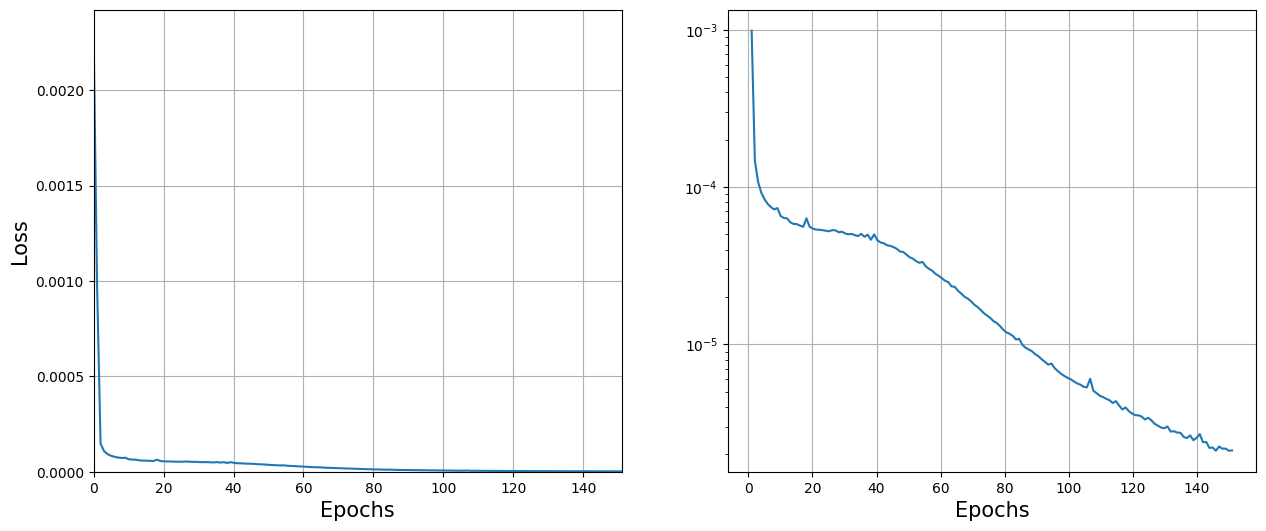

In [12]:
### Analysis  
epochs = len(trainer.loss_list)
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(1, 2, 1)

ax.plot(np.linspace(0, epochs, len(trainer.loss_list)), trainer.loss_list)
ax.grid()

ax.set_xlabel('Epochs', fontsize=15)
ax.set_ylabel('Loss', fontsize=15)
ax.set_xlim(0, epochs)
ax.set_ylim(bottom=0)

ax2 = fig.add_subplot(1, 2, 2)

e_pts = np.linspace(0, epochs, len(trainer.loss_list))
ax2.plot(e_pts[1:], trainer.loss_list[1:])

#ax2.set_ylim()
ax2.grid()
#plt.xscale('log')~
#
ax2.set_yscale('log')
#ax2.set_xscale('log')
ax2.set_xlabel('Epochs', fontsize=15)

In [14]:
print('Final Loss: ', trainer.loss())
print('Number of epochs: ', trainer.epoch_trained)

Final Loss:  1.8794681864164886e-06
Number of epochs:  150


# Analyzing the trained model

## Data Generation with trained NODE, Dynamic Parameter

In [15]:
a = torch.linspace(-2, 2, 10)  
b = torch.linspace(-2, 2, 10)  
c = torch.arange(-1, 8.0, 0.1)

pts = torch.cartesian_prod(a, b, c)  # (num_pts, dim)
pts.shape
t_Start_pred = 0; t_Final_pred = 20; dt_pred = 0.05
t_eval_pred = torch.arange(t_Start_pred, t_Final_pred, dt_pred)

In [16]:
pts.shape

torch.Size([9000, 3])

In [17]:
model.drdt = 0.1

node_data = odeint(func=model, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})


node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(400, 9000, 3)
(400, 9000, 3)


### Plotting phase space

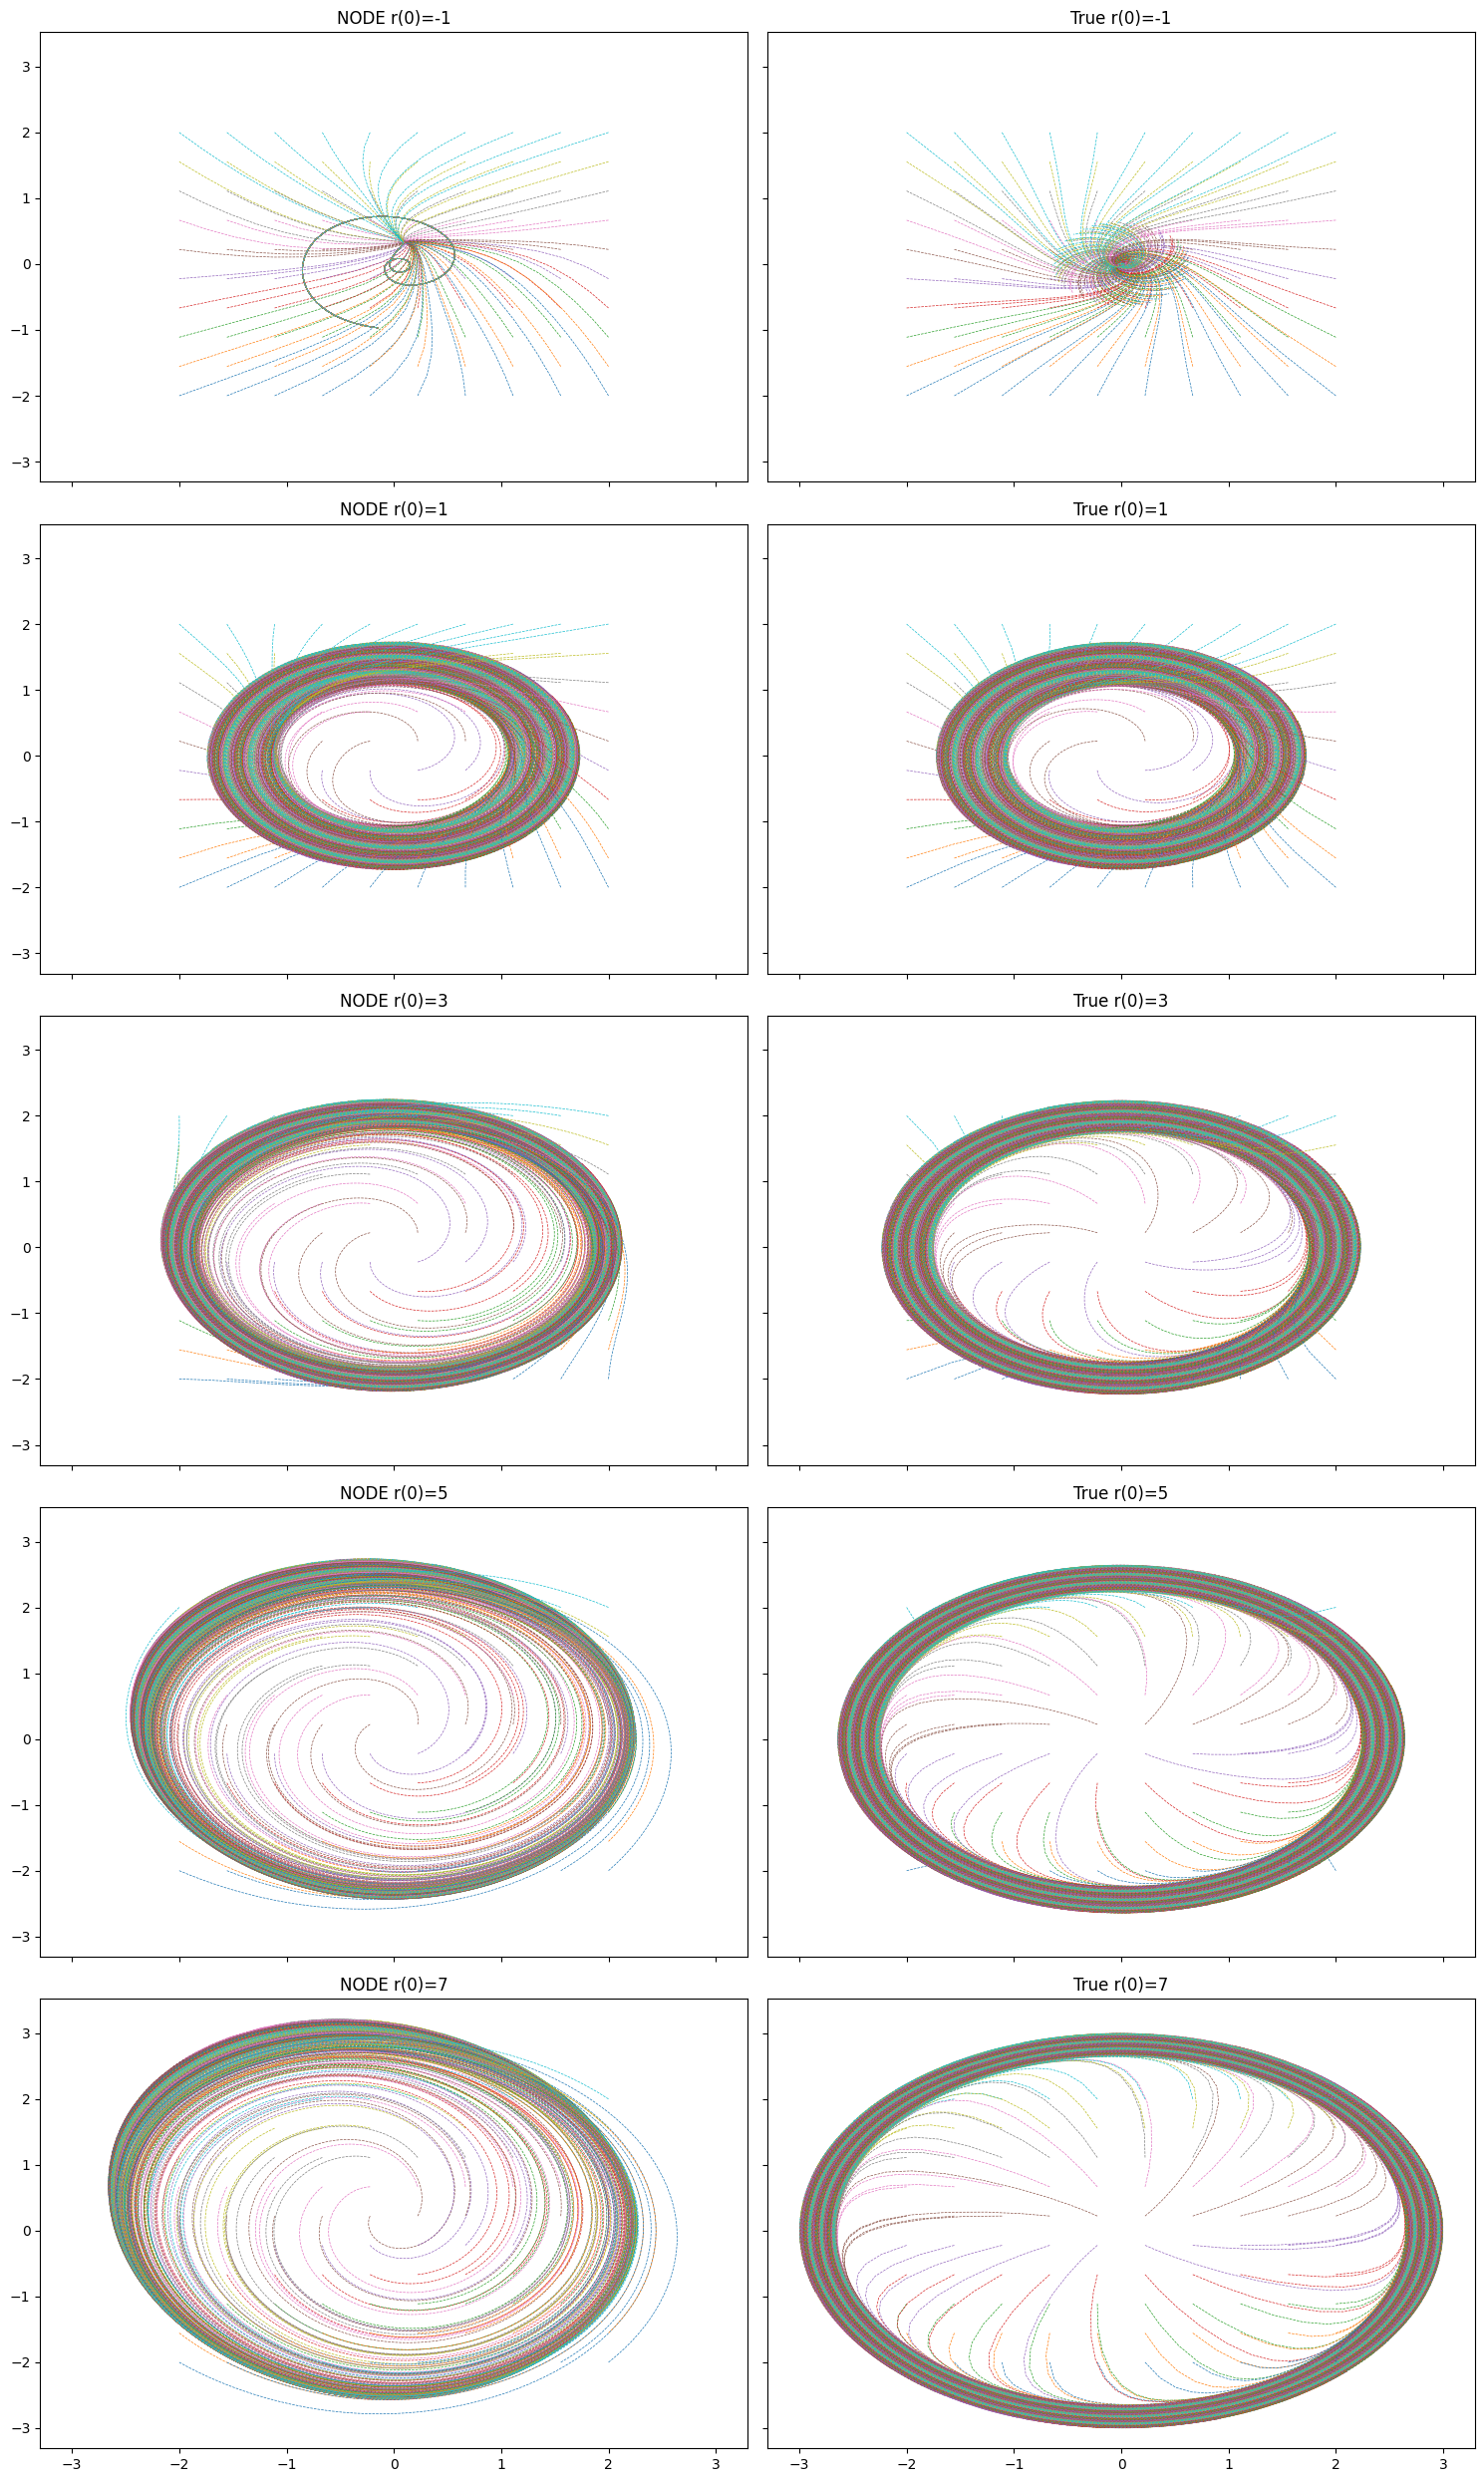

In [18]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0],
                    node_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0],
                    true_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

## Static parameter (Extrapolation)

In [19]:
model.drdt = 0.0
lc.gamma = 0.0

node_data = odeint(func=model, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})
true_data = odeint(func=lc.f, y0=pts, t=t_eval_pred, method='rk4', options={'step_size': dt_pred})


node_data = node_data.detach().numpy()
true_data = true_data.detach().numpy()

print(node_data.shape); print(true_data.shape)

(400, 9000, 3)
(400, 9000, 3)


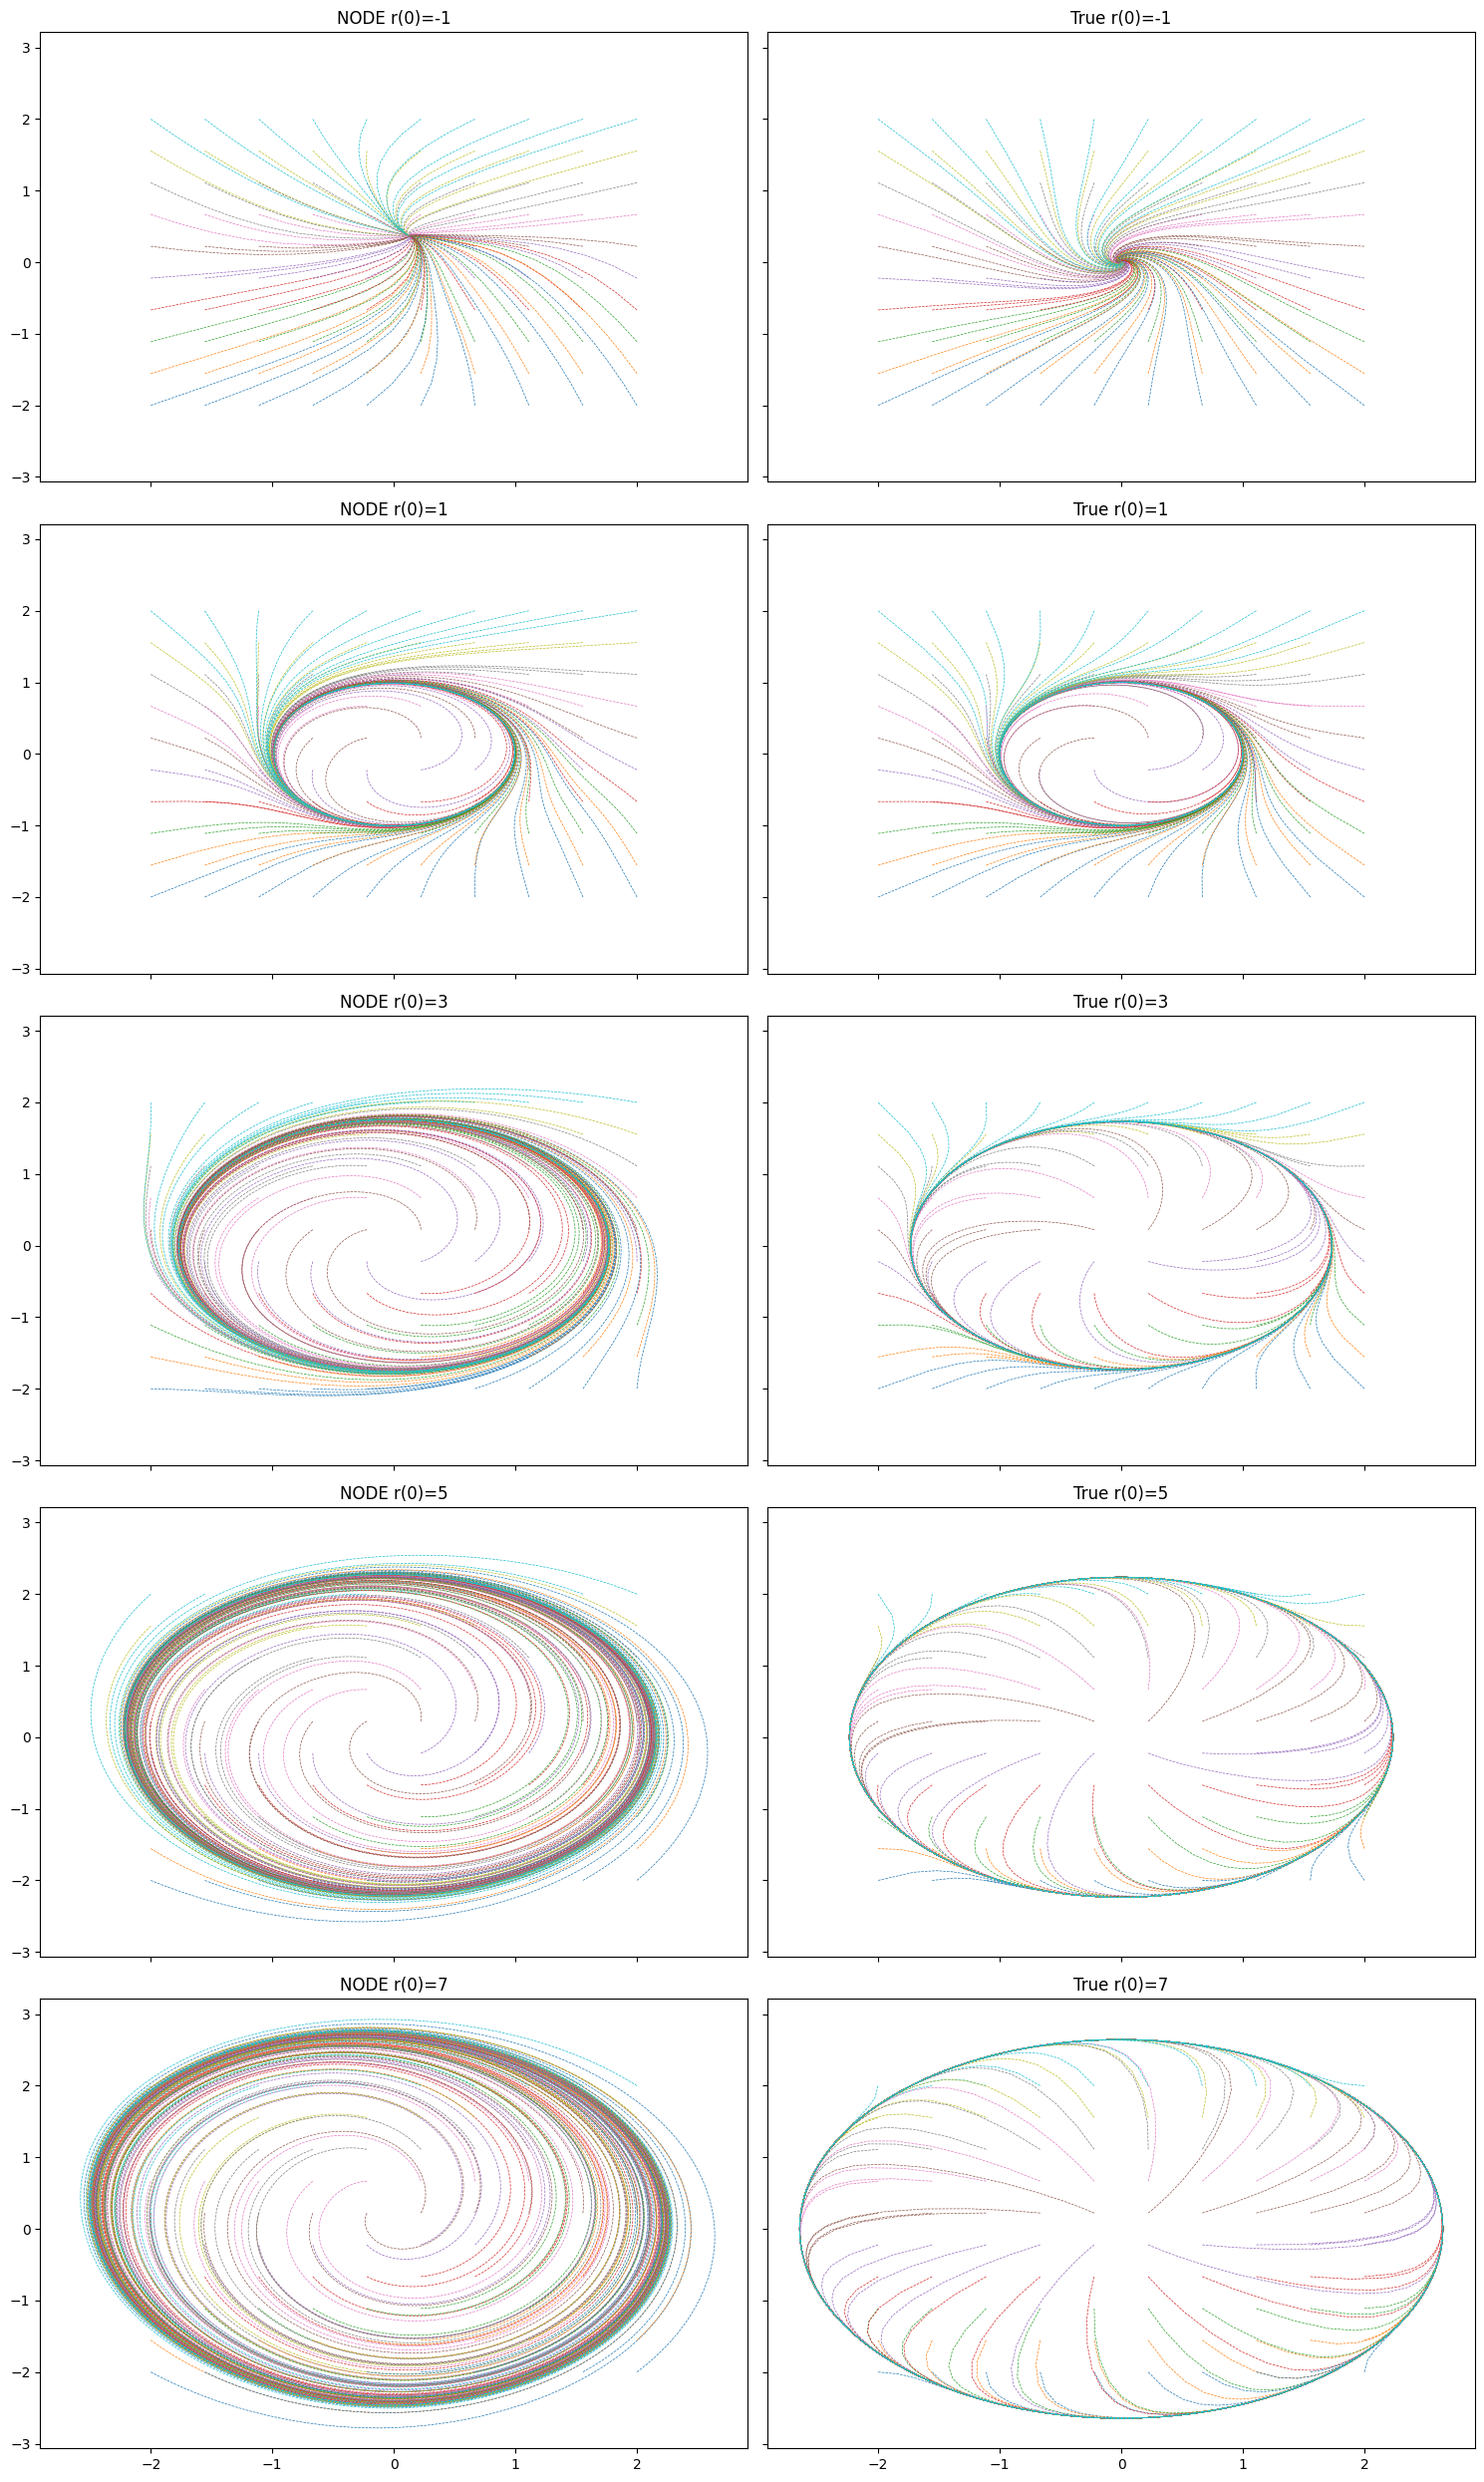

In [20]:
r_plots = [-1, 1, 3, 5, 7]
fig, axes = plt.subplots(len(r_plots), 2, figsize=(15, 5*len(r_plots)), sharex=True, sharey=True)

for i, r in enumerate(r_plots):
    axes[i, 0].plot(node_data[:, pts[:, 2] == r, 0],
                    node_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 1].plot(true_data[:, pts[:, 2] == r, 0],
                    true_data[:, pts[:, 2] == r, 1],
                    linewidth=0.5, alpha=1, linestyle='--')
    axes[i, 0].set_title(f"NODE r(0)={r}")
    axes[i, 1].set_title(f"True r(0)={r}")

plt.tight_layout()
plt.show()

In [21]:
# Plotting time traces: 